#                                                Pneumonia prediction using Convonutional Neural Networks


### **Dataset**: The dataset is taken from kaggle which consists of 5856 image files 

### **Model**:

    - Convolutional neural network was choosen for this project as it performed better when compared to pretrained models such as ResNet50 or Xception

    - This project consists of two models named as model_1 and model_2 with each of them having the same number of convonutional layer but differ in activation funtions


### Pneumonia:
     It is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing.

     Pneumonia can range in seriousness from mild to life-threatening. It is most serious for infants and young children, people older than age 65, and people with health problems or weakened immune systems.

### Symptoms:

    - Chest pain when you breathe or cough
    - Confusion or changes in mental awareness (in adults age 65 and older)
    - Cough, which may produce phlegm
    - Fatigue
    - Fever, sweating and shaking chills
    - Lower than normal body temperature (in adults older than age 65 and people with weak immune systems)
    - Nausea, vomiting or diarrhea
    - Shortness of breath

### Detection:

    -Chest X-ray to look for inflammation in your lungs. A chest X-ray is often used to diagnose pneumonia.
    -Blood tests, such as a complete blood count (CBC) to see whether your immune system is fighting an infection.
    -Pulse oximetry to measure how much oxygen is in your blood. Pneumonia can keep your lungs from moving enough oxygen into your blood. To measure the levels, a small sensor called a pulse oximeter is attached to your finger or ear.

This project may help or assist doctors or radiologits make a sure diagnosis of this disease even if the x-ray is having some issues or is of bad quality or give a first diagnosis to primary health care personnel an idea about the disease when there very less resourses available 

### What is a CNN ?

A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

The architecture of a ConvNet is analogous to that of the connectivity pattern of Neurons in the Human Brain and was inspired by the organization of the Visual Cortex. Individual neurons respond to stimuli only in a restricted region of the visual field known as the Receptive Field. A collection of such fields overlap to cover the entire visual area.

The objective of the Convolution Operation is to extract the high-level features such as edges, from the input image. ConvNets need not be limited to only one Convolutional Layer. Conventionally, the first ConvLayer is responsible for capturing the Low-Level features such as edges, color, gradient orientation, etc. With added layers, the architecture adapts to the High-Level features as well, giving us a network which has the wholesome understanding of images in the dataset, similar to how we would.


<img src="https://miro.medium.com/max/494/1*1VJDP6qDY9-ExTuQVEOlVg.gif" width="500" align="center">

<br>

Similar to the Convolutional Layer, the Pooling layer is responsible for reducing the spatial size of the Convolved Feature. This is to decrease the computational power required to process the data through dimensionality reduction. Furthermore, it is useful for extracting dominant features which are rotational and positional invariant, thus maintaining the process of effectively training of the model.

<img src="https://miro.medium.com/max/495/1*uoWYsCV5vBU8SHFPAPao-w.gif" width="500" align="center">

<br>

__ ___________________________________________________________________________________________________________________________________________________________________ __

Importing the requried libraries

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
import matplotlib 
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

The picture below depicts chest x-ray person having pneumonia 

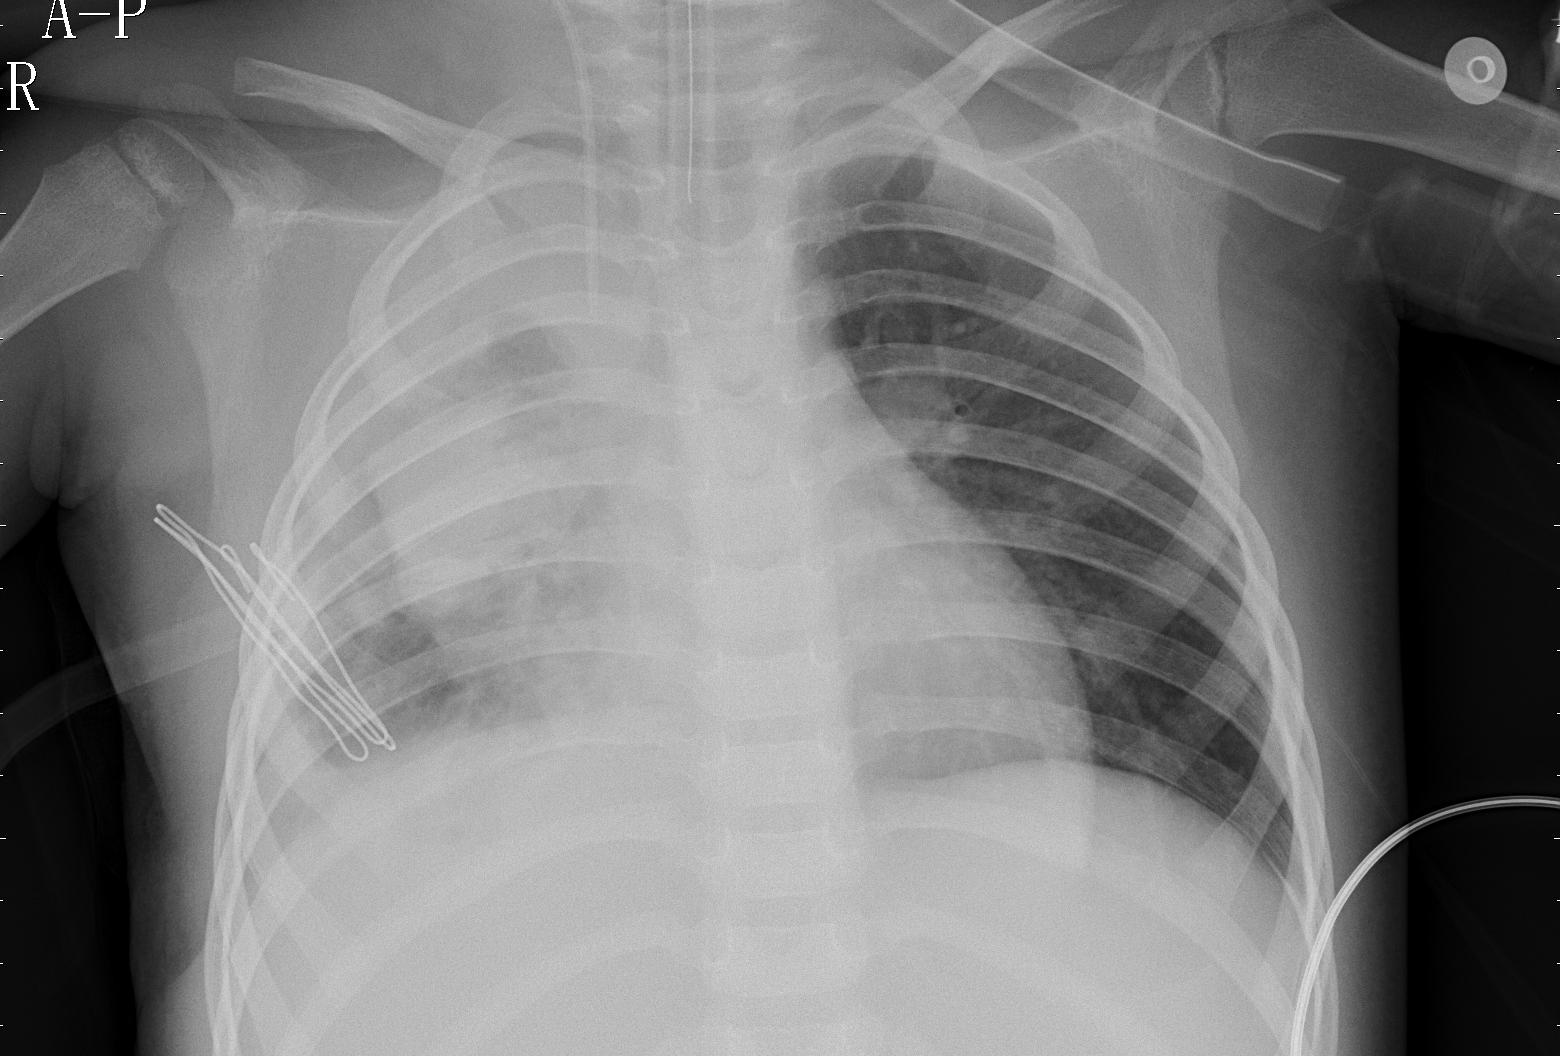

In [2]:
fullname = './archive/chest_xray/train/PNEUMONIA/person1940_bacteria_4861.jpeg'
load_img(fullname)

The batch size is set to 64 and the height and width of all the images is set to 200 , 200.

In [50]:
batch_size = 64
img_height = 200
img_width = 200

Loading the training data

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    './archive/chest_xray/train' ,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 5216 files belonging to 2 classes.


Loading the validation data

In [51]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    './archive/chest_xray/val' ,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
    )

Found 16 files belonging to 2 classes.


Loading the test data

In [52]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    './archive/chest_xray/test' ,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 624 files belonging to 2 classes.


Printing the class names to which the training data is classified into

In [8]:
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']


A sample of training data 

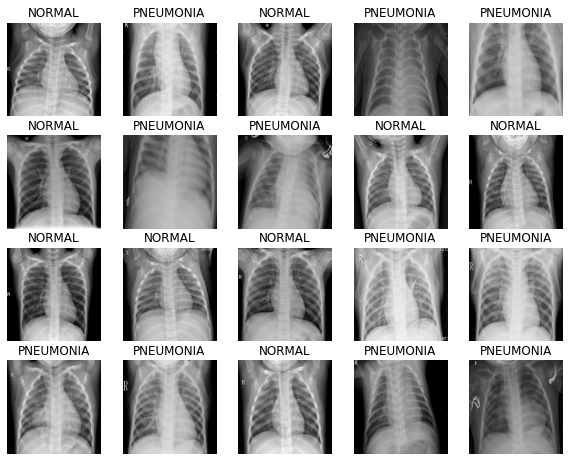

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


tf.data builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as AUTOTUNE. While the input pipeline is running, tf.data tracks the time spent in each operation, so that these times can be fed into the optimization algorithm.

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Applying the normalization layer and rescaling the inputs

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


The first model (model_1) is a CNN model which has 9 layers with each layer having the rectified linear unit (relu) activation function which is a non linear activation function.

We use MaxPooling2D so as to Downsample the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

In [56]:
num_classes = len(class_names)

model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

The optimizer used in this model is the adam optimizer available in the tensorflow.keras.optimizers library

The loss funtion used is the SparseCategoricalCrossentropy and we track the accuracy metrics

In [59]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 50, 50, 64)       

The model is trained over 50 epochs

In [60]:
epochs=50
history1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
163/163 [==============================] - 10s 57ms/step - loss: 0.1336 - accuracy: 0.9532 - val_loss: 0.3800 - val_accuracy: 0.7500
Epoch 2/50
163/163 [==============================] - 6s 40ms/step - loss: 0.0765 - accuracy: 0.9726 - val_loss: 0.2082 - val_accuracy: 0.9375
Epoch 3/50
163/163 [==============================] - 6s 36ms/step - loss: 0.0565 - accuracy: 0.9791 - val_loss: 0.3325 - val_accuracy: 0.8125
Epoch 4/50
163/163 [==============================] - 6s 36ms/step - loss: 0.0460 - accuracy: 0.9835 - val_loss: 0.1551 - val_accuracy: 0.8750
Epoch 5/50
163/163 [==============================] - 6s 37ms/step - loss: 0.0296 - accuracy: 0.9896 - val_loss: 0.0541 - val_accuracy: 1.0000
Epoch 6/50
163/163 [==============================] - 6s 36ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.0235 - val_accuracy: 1.0000
Epoch 7/50
163/163 [==============================] - 6s 36ms/step - loss: 0.0610 - accuracy: 0.9785 - val_loss: 0.0179 - val_accuracy: 1.000

The training and validation accuracies are plotted

The training and validation losses are plotted

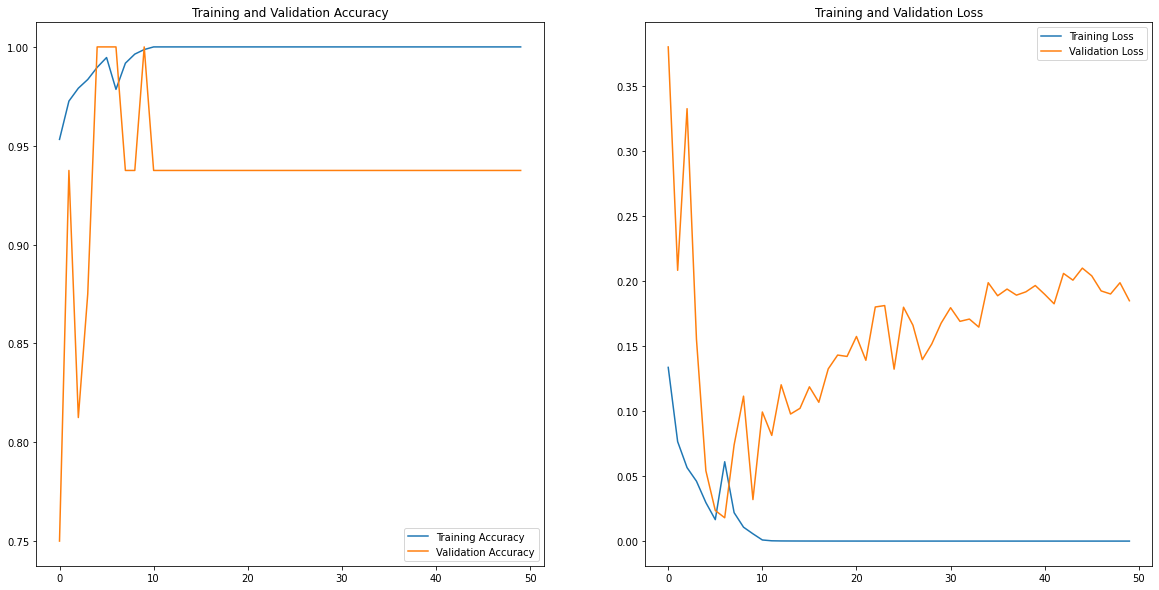

In [67]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The accuracy of the model_1 when evaluated against the test data is 74.36% even after training for 50 epochs 

In [61]:
model_1.evaluate(test_ds)

10/10 [==============================] - 2s 88ms/step - loss: 5.9190 - accuracy: 0.7436


[5.918984413146973, 0.7435897588729858]

## Data agumentation is used for the second model so as to prevent overfitting the training data

In [29]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

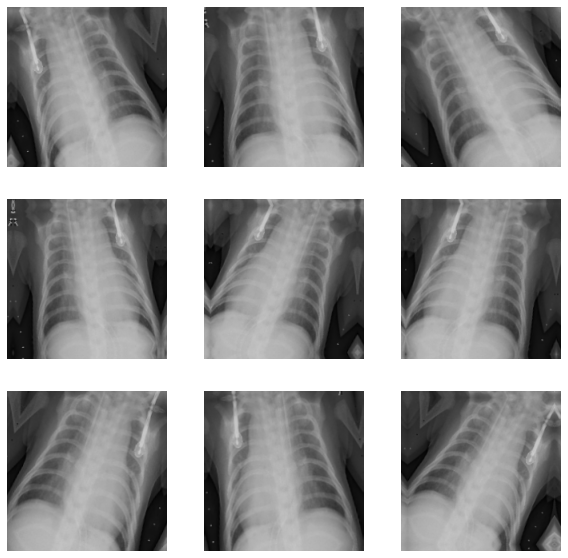

In [30]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [31]:
num_classes = len(class_names)

The first model (model_2) is a CNN model which has 9 layers with each layer having the softsign activation function which is a non linear activation function.

We use MaxPooling2D so as to Downsample the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

We use Dropout function which randomly sets elements to zero to prevent overfitting.

In [68]:
activation_func = 'softsign'

model_2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation=activation_func),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation=activation_func),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation=activation_func),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=activation_func),
  layers.Dense(num_classes)
])

The optimizer used in this model is the adam optimizer available in the tensorflow.keras.optimizers library

The loss funtion used is the SparseCategoricalCrossentropy and we track the accuracy metrics

In [69]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

The model is trained over 50 epochs

In [70]:
epochs = 50

history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/50
163/163 [==============================] - 9s 54ms/step - loss: 0.8306 - accuracy: 0.7255 - val_loss: 0.8229 - val_accuracy: 0.5000
Epoch 2/50
163/163 [==============================] - 9s 53ms/step - loss: 0.5304 - accuracy: 0.7433 - val_loss: 0.8023 - val_accuracy: 0.6250
Epoch 3/50
163/163 [==============================] - 9s 53ms/step - loss: 0.2997 - accuracy: 0.8664 - val_loss: 0.6604 - val_accuracy: 0.7500
Epoch 4/50
163/163 [==============================] - 9s 53ms/step - loss: 0.2318 - accuracy: 0.9015 - val_loss: 0.9396 - val_accuracy: 0.6250
Epoch 5/50
163/163 [==============================] - 9s 53ms/step - loss: 0.2002 - accuracy: 0.9187 - val_loss: 0.4406 - val_accuracy: 0.8125
Epoch 6/50
163/163 [==============================] - 9s 54ms/step - loss: 0.1915 - accuracy: 0.9212 - val_loss: 0.4708 - val_accuracy: 0.6875
Epoch 7/50
163/163 [==============================] - 9s 54ms/step - loss: 0.1696 - accuracy: 0.9342 - val_loss: 0.5343 - val_accuracy: 0.8125

The training and validation accuracies are plotted

The training and validation losses are plotted

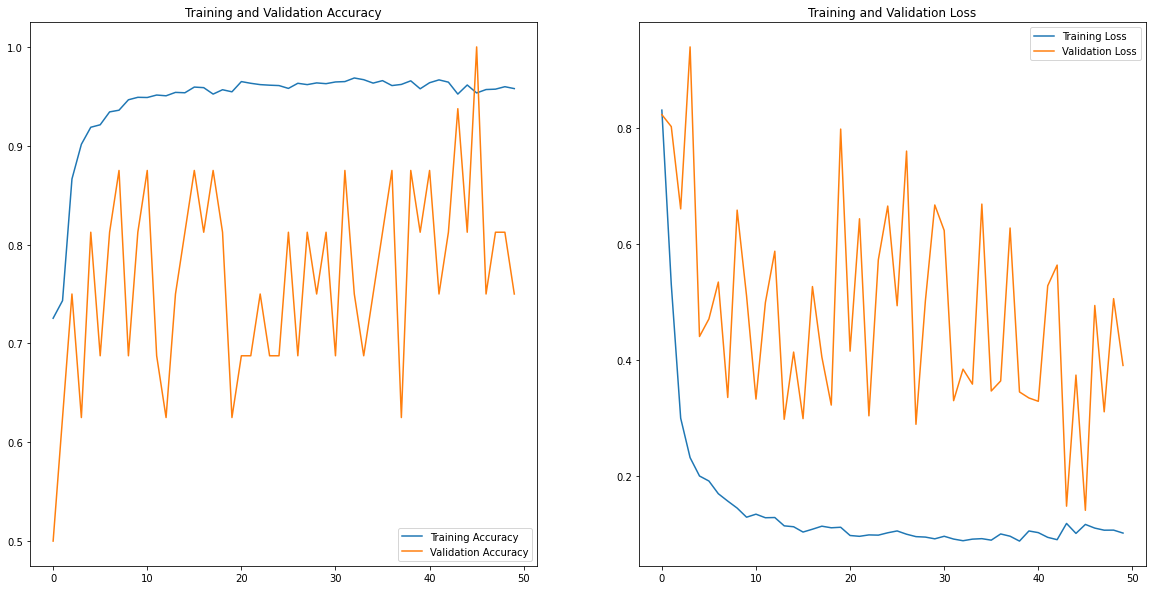

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The accuracy of the model_1 when evaluated against the test data is 54.13% even after training for 50 epochs 

In [74]:
model_2.evaluate(test_ds)

10/10 [==============================] - 2s 52ms/step - loss: 0.4496 - accuracy: 0.8413


[0.44961389899253845, 0.8413461446762085]

A random image which was taken from the internet and tested in model_2 and it predicted the correct output with 99.40% confidence

In [76]:
path = './archive/chest_xray/test/images (1).jfif'
#test1_path = tf.keras.utils.get_file('person16_virus44', origin=path)

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_2.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to PNEUMONIA with a 99.40 percent confidence.
